# FETCH DATA FOR THE CRYPTO CURRENCIES FROM BINANCE

In [1]:
# FETCHING THE DATA FOR CRYPTO CURRENECIES BTC,DOGE,BNB,CARDANO,ETH,SOLANA

import ccxt
import pandas as pd
import numpy as np
exchange=ccxt.binance()
symbols=['BTC/USDT','ETH/USDT','DOGE/USDT','BNB/USDT','ADA/USDT','SOL/USDT']
timeframe='1h'
limit=1000
df_dict={}
for symbol in symbols:
    ohlcv=exchange.fetch_ohlcv(symbol,timeframe=timeframe,limit=limit)
    df=pd.DataFrame(ohlcv,columns=['Timestamp','Open','High','Low','Close','Volume'])
    df['Timestamp']=pd.to_datetime(df['Timestamp'],unit='ms')
    df_dict[symbol]=df

   

df_list=[]

for symbol,df in df_dict.items():
    df['symbol']=symbol
    df_list.append(df)
DATA=pd.concat(df_dict,ignore_index=True)
DATA.dropna(inplace=True)
DATA.set_index('Timestamp',inplace=True)
DATA['symbol']=DATA['symbol'].astype(str).str.strip()
DATA_1=pd.concat(df_dict,axis=1)
DATA.to_csv('CRYPTO_PROJECT_DATA.csv')    # BETTER FOR EXCEL MODELLING AND ANALYSIS

DATA_1  # BETTER FOR PYTHON ANALYSIS
DATA_1['TIME']=DATA_1['BTC/USDT']['Timestamp']
DATA_1.set_index('TIME',inplace=True)

# This should correctly drop all Timestamp columns
columns_to_drop = [(symbol, 'Timestamp') for symbol in symbols]
DATA_1 = DATA_1.drop(columns=columns_to_drop)
columns_to_drop = [(symbol, 'symbol') for symbol in symbols]
DATA_1 = DATA_1.drop(columns=columns_to_drop)


     

# PLOTTING THE ABOVE DATA AS INTERACTIVE GRAPHS

In [ ]:
# PLOTIING CANDLE STICK PLOTS INERACTUIVE FOR THE GIVEN DATA



import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import webbrowser
import os

# Get unique symbols from your columns
symbols = list(set([col[0] for col in DATA_1.columns]))

# Create plots for each symbol
for symbol in symbols:
    try:
        # Extract OHLCV data for the specific symbol
        coin_data = pd.DataFrame({
            'Open': DATA_1[(symbol, 'Open')],
            'High': DATA_1[(symbol, 'High')],
            'Low': DATA_1[(symbol, 'Low')],
            'Close': DATA_1[(symbol, 'Close')],
            'Volume': DATA_1[(symbol, 'Volume')]
        })
        
        # Create figure with secondary y-axis
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        
        # Add candlestick
        fig.add_trace(
            go.Candlestick(
                x=coin_data.index,
                open=coin_data['Open'],
                high=coin_data['High'],
                low=coin_data['Low'],
                close=coin_data['Close'],
                name='OHLC'
            ),
            secondary_y=False
        )
        
        # Calculate colors for volume bars
        colors = ['red' if close < open else 'green' 
                 for close, open in zip(coin_data['Close'], coin_data['Open'])]
        
        # Add volume bars
        fig.add_trace(
            go.Bar(
                x=coin_data.index,
                y=coin_data['Volume'],
                name='Volume',
                marker=dict(color=colors, opacity=0.5)
            ),
            secondary_y=True
        )
        
        # Update layout
        fig.update_layout(
            title=dict(
                text=f'{symbol} - Price and Volume Over Time',
                x=0.5,
                xanchor='center'
            ),
            xaxis_title='Date',
            yaxis_title='Price (USD)',
            template='plotly_dark',
            height=800,
            width=1200,
            showlegend=True,
            xaxis=dict(
                rangeslider=dict(visible=True),
                type='date'
            ),
            yaxis=dict(showgrid=True),
            yaxis2=dict(showgrid=False)
        )
        
        # Update y-axes titles
        fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
        fig.update_yaxes(title_text="Volume", secondary_y=True)
        
        # Save the plot as an HTML file
        output_file = f"{symbol.replace('/', '_')}_chart.html"
        fig.write_html(output_file)
        
        # Open the plot in the default web browser
        webbrowser.open('file://' + os.path.realpath(output_file))
        
        print(f"Chart for {symbol} has been saved to {output_file} and opened in your browser")
        
    except Exception as e:
        print(f"Error plotting {symbol}: {str(e)}")
        print("\nColumns in DATA_1:")
        print(DATA_1.columns)


# Add this at the top of your script
output_directory = "charts"  # Change this to your preferred directory

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Then modify the output_file line to:
output_file = os.path.join(output_directory, f"{symbol.replace('/', '_')}_chart.html")



# CALCUALTING THE STATISTICAL PARAMETERS

In [2]:
# calculating statistical parameters
import os

RESULTS_DIR='RESULTS'
os.makedirs(RESULTS_DIR,exist_ok=True)



LOG_RETURNS=pd.DataFrame()
CLOSE_DATA=pd.DataFrame()
LOG_RETURNS_MONTHLY={}
ALGO_DATAFRAME=pd.DataFrame()


# For cryptocurrency pairs
symbols=['BTC/USDT','ETH/USDT','DOGE/USDT','BNB/USDT','ADA/USDT','SOL/USDT']

for symbol in symbols:
    # Calculate log returns using the MultiIndex structure
    DATA_1[(symbol, 'Log_return')] = np.log(DATA_1[(symbol, 'Close')] / DATA_1[(symbol, 'Close')].shift(1))
    # Store only the calculated returns in LOG_RETURN
    
    LOG_RETURNS[symbol]=DATA_1[(symbol, 'Log_return')]
    
    CLOSE_DATA[symbol]=DATA_1[(symbol,'Close')]
    CLOSE_DATA[f'{symbol}_Drawdown']=(CLOSE_DATA[symbol]-CLOSE_DATA[symbol].cummax())/(CLOSE_DATA[symbol].cummax())*100
    
    ALGO_DATAFRAME[f'{symbol}_high']=DATA_1[(symbol,'High')]
    ALGO_DATAFRAME[f'{symbol}_low']=DATA_1[(symbol,'Low')]
    ALGO_DATAFRAME[f'{symbol}']=DATA_1[(symbol,'Close')]
    
    
    LOG_RETURNS.dropna(inplace=True)
    
    LOG_RETURNS_MONTHLY[f'{symbol}_MONTHLY']=LOG_RETURNS[symbol].tail(720).sum()
    
    
    
    DATA_1.to_csv(f'{RESULTS_DIR}/CRYPTO_PROJECT_DATA.csv')
      

# FILTERING AND CALCULATNG COV AND CORR MATRIX



COVARIENCE_MATRIX = LOG_RETURNS.cov() # CALCULATING COVAEIRENCENATRIX
CORRELATION_MATRIX = LOG_RETURNS.corr() # CALCULATING CORRELATION MATRIX


VOlatility={}
RISK_FREE_RATE=0.004988 ## THE 
## CALCULATING QUANTITAIVE RATIOS 
RATIOS={}
 
for symbol in symbols:
    VOlatility[symbol]={'HOURLY':LOG_RETURNS[symbol].std(),'DAILY':(LOG_RETURNS[symbol].std()*np.sqrt(24)),'WEEKLY':(LOG_RETURNS[symbol].std()*np.sqrt(168)),'MONTHLY':(LOG_RETURNS[symbol].std()*np.sqrt(720))}
    RATIOS[f'{symbol}_sharpe_ratio']=((LOG_RETURNS_MONTHLY[f'{symbol}_MONTHLY']-RISK_FREE_RATE)/VOlatility[symbol]['MONTHLY'])
    RATIOS[f'{symbol}_CALMAR_RATIO']=LOG_RETURNS_MONTHLY[f'{symbol}_MONTHLY']/(abs(np.log(1+(CLOSE_DATA[f'{symbol}_Drawdown'].min())/100)))
    

LIST_OF_STATISTICAL_MEASURES=[CORRELATION_MATRIX,COVARIENCE_MATRIX,CLOSE_DATA,LOG_RETURNS,VOlatility,RATIOS,LOG_RETURNS_MONTHLY,ALGO_DATAFRAME]

CORRELATION_MATRIX.to_csv(f'{RESULTS_DIR}/CORRELATION_MATRIX.csv')      
COVARIENCE_MATRIX.to_csv(f'{RESULTS_DIR}/COVARIENCE_MATRIX.csv')
pd.DataFrame(RATIOS,index=[0]).to_csv(f'{RESULTS_DIR}/RATIOS.csv')
pd.DataFrame(VOlatility).to_csv(f'{RESULTS_DIR}/VOlatility.csv')
pd.DataFrame(LOG_RETURNS_MONTHLY,index=[0]).to_csv(f'{RESULTS_DIR}/LOG_RETURNS_MONTHLY.csv')  





# PLOTTING  GRAPHS LIKE MAX DRAWDOWNS CLOSE PRICES CORRELATION HEATMAP 

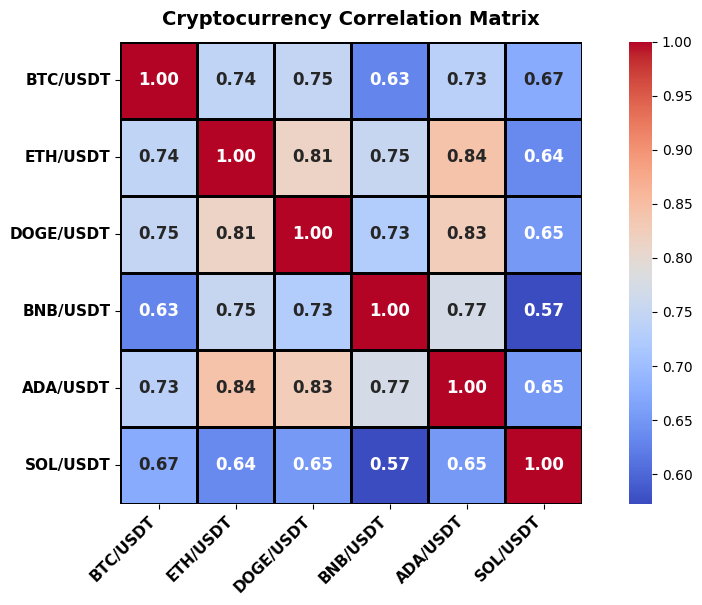

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

#HEAT MAP FOR THE CORRELATION MATRIX
plt.figure(figsize=(12,6))
sns.heatmap(CORRELATION_MATRIX,annot=True,fmt='.2f'
            ,cmap='coolwarm',linewidths=2,linecolor='black',square=True,cbar=True,annot_kws={'size':12,'weight':'bold'}
            ,xticklabels=CORRELATION_MATRIX.columns,yticklabels=CORRELATION_MATRIX.columns)
plt.title('Cryptocurrency Correlation Matrix',fontsize=14,fontweight='bold',pad=12)
plt.xticks(rotation=45,ha='right',fontsize=11,fontweight='bold')
plt.yticks(fontsize=11,fontweight='bold',rotation=0)

plt.savefig(f'{RESULTS_DIR}/CORRELATION_MATRIX_HEATMAP.png')

plt.show()


In [ ]:
 ## PLOT THE DRAW_DOWN FOR EACH CRYPTO 

import matplotlib.pyplot as plt

# Use a style that exists
plt.style.use('seaborn-v0_8-darkgrid')  # Alternatively, try 

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each symbol's drawdown
for symbol in symbols:
    ax.plot(CLOSE_DATA.index, CLOSE_DATA[f"{symbol}_Drawdown"], label=symbol, linewidth=1.5, alpha=0.8)

# Add labels, title, and legend
ax.set_title("Drawdown Over Time", fontsize=14, fontweight="bold")
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Drawdown", fontsize=12)
ax.legend(title="Symbols", fontsize=10, title_fontsize=12)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)  # Baseline at 0 drawdown

plt.savefig(f'{RESULTS_DIR}/CRYPTO_DRAW_DOWN.png')
plt.show()



In [ ]:
# PLOT THE RISK-RETURN PLOT
import matplotlib.pyplot as plt
returns=[ LOG_RETURNS_MONTHLY[f'{symbol}_MONTHLY'] for symbol in symbols]
volatilities=[VOlatility[f'{symbol}']['MONTHLY'] for symbol in symbols]

plt.figure(figsize=[12,6])
plt.scatter(volatilities,returns,color='dodgerblue',s=100,edgecolors='black',alpha=0.8)

for i,symbol in enumerate(symbols):
    plt.text(volatilities[i]+0.002,returns[i],symbol,fontsize=12,fontweight='bold',color='black')

plt.xlabel('volatility(Risk)',fontsize=14)
plt.ylabel('Return',fontsize=14)
plt.title('Risk-Return Scatter Plot',fontsize=16,fontweight='bold')
plt.grid(True,linestyle='--',alpha=0.6)

plt.savefig(f'{RESULTS_DIR}/RISK_RETURN_PLOT.png')
plt.show()


## PORTFOLIO OPTIMISATION FOR MIN VARIANCE PORTFOLIO FOR THE GIVEN MEAN RETURN AND VOLATILITY OF CRYPTO_CURRENCY

In [ ]:
import scipy as sc
import numpy as np

COVARIENCE_MATRIX_MONTHLY=720*COVARIENCE_MATRIX
w_0=np.array([1/len(symbols)]*len(symbols)).reshape(len(symbols),1)     # Equal weifhted portfolio 
sigma_0=w_0.T @ COVARIENCE_MATRIX_MONTHLY @ w_0                           # INITIAL VARIENCE 

# OPTIMISATION USING THE MIN VARIENCE PORTFOLIO USING LAGRANGE MULTIPLIER FOR OPTIMISATION


import numpy as np
from scipy.optimize import minimize

# Convert DataFrame to numpy array and flatten w_0
COVARIENCE_MATRIX_MONTHLY = np.array(COVARIENCE_MATRIX_MONTHLY)
w_0 = w_0.flatten()  # Convert from (n,1) to (n,)

def get_min_variance_portfolio(cov_matrix, initial_weights):
    # Objective function: Portfolio Variance
    def objective(weights):
        weights = np.array(weights).reshape(-1, 1)  # Reshape weights for matrix multiplication
        return (weights.T @ cov_matrix @ weights)[0,0]  # Get scalar value
    
    # Number of assets
    n = len(initial_weights)
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Sum of weights = 1
    ]
    
    # Bounds for weights (all non-negative)
    bounds = tuple((0, None) for _ in range(n))
    
    # Optimization
    result = minimize(
        objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x, result.fun

# Run optimization using your stored data
optimal_weights, PORTFOLIO_variance = get_min_variance_portfolio(COVARIENCE_MATRIX_MONTHLY, w_0)

# Print results
print("\nOptimal Portfolio Weights:")
for i, weight in enumerate(optimal_weights):
    print(f"Asset {i+1}: {weight:.4f}")
print(f"\nMinimum Portfolio Variance: {PORTFOLIO_variance:.6f}")
print(f"Sum of weights: {np.sum(optimal_weights):.6f}")

RETURNS=[]
for symbol in symbols:
    RETURNS.append(LOG_RETURNS_MONTHLY[f'{symbol}_MONTHLY'])
    
RETURNS=np.array(RETURNS)
optimal_weights

PORTFOLIO_RETURN= RETURNS.T @ optimal_weights
PORTFOLIO_variance



## DEVELOP MEAN REVERSION AND MOMMENTUM STRATEGY FOR EACH COIN AND CHECK FOR RETURNS AFTER THE END OF TRADING SESSION THE INDIACTIR

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class CRYPTO_BACKTESTING:
    def __init__(self, DATAFRAME, SYMBOLS, 
                 short_period=20, 
                 long_period=100,
                 stop_loss=0.02,
                 take_profit=0.05,
                 commission=0.001,
                 initial_capital=10000):
        """
        Initialize the backtesting system
        
        Parameters:
        -----------
        DATAFRAME : pd.DataFrame
            Price data for all symbols
        SYMBOLS : list
            List of cryptocurrency symbols
        short_period : int
            Short moving average period
        long_period : int
            Long moving average period
        stop_loss : float
            Stop loss percentage
        take_profit : float
            Take profit percentage
        commission : float
            Transaction commission percentage
        initial_capital : float
            Initial capital for trading
        """
        self.DF = DATAFRAME.copy()
        self.SYMBOLS = SYMBOLS
        self.SHORT_PERIOD = short_period
        self.LONG_PERIOD = long_period
        self.STOP_LOSS = stop_loss
        self.TAKE_PROFIT = take_profit
        self.COMMISSION = commission
        self.INITIAL_CAPITAL = initial_capital
        self.RESULTS = pd.DataFrame()
        self.TRADES = []
        
        # Validate input data
        self._validate_data()

    def _validate_data(self):
        """Validate input data"""
        try:
            # Check for missing values
            if self.DF.isnull().any().any():
                self.DF = self.DF.fillna(method='ffill')
            
            # Check if all symbols exist in dataframe
            for symbol in self.SYMBOLS:
                if symbol not in self.DF.columns:
                    raise ValueError(f"Symbol {symbol} not found in dataframe")
                    
        except Exception as e:
            print(f"Data validation error: {str(e)}")
            raise

    def populate_average_crossover_indicator(self):
        """Calculate moving averages for each symbol"""
        try:
            for symbol in self.SYMBOLS:
                # Calculate SMAs
                self.DF[f'{symbol}_SMA_{self.SHORT_PERIOD}'] = self.DF[symbol].rolling(
                    window=self.SHORT_PERIOD, min_periods=1).mean()
                self.DF[f'{symbol}_SMA_{self.LONG_PERIOD}'] = self.DF[symbol].rolling(
                    window=self.LONG_PERIOD, min_periods=1).mean()
                
                # Calculate additional indicators
                self.DF[f'{symbol}_STD'] = self.DF[symbol].rolling(window=20).std()
                self.DF[f'{symbol}_Upper_Band'] = (self.DF[f'{symbol}_SMA_{self.SHORT_PERIOD}'] + 
                                                  (2 * self.DF[f'{symbol}_STD']))
                self.DF[f'{symbol}_Lower_Band'] = (self.DF[f'{symbol}_SMA_{self.SHORT_PERIOD}'] - 
                                                  (2 * self.DF[f'{symbol}_STD']))
            return True
        except Exception as e:
            print(f"Error calculating indicators: {str(e)}")
            return False

    def populate_average_crossover_signals(self):
        """Generate buy and sell signals"""
        try:
            for symbol in self.SYMBOLS:
                # Initialize signal columns
                self.DF[f'{symbol}_BUY'] = False
                self.DF[f'{symbol}_SELL'] = False
                
                short_sma = self.DF[f'{symbol}_SMA_{self.SHORT_PERIOD}']
                long_sma = self.DF[f'{symbol}_SMA_{self.LONG_PERIOD}']
                
                # Generate signals
                self.DF[f'{symbol}_BUY'] = (
                    (short_sma > long_sma) & 
                    (short_sma.shift(1) <= long_sma.shift(1))
                )
                
                self.DF[f'{symbol}_SELL'] = (
                    (short_sma < long_sma) & 
                    (short_sma.shift(1) >= long_sma.shift(1))
                )
            return True
        except Exception as e:
            print(f"Error generating signals: {str(e)}")
            return False

    def calculate_position_size(self, capital, price):
        """Calculate position size based on risk"""
        risk_amount = capital * self.STOP_LOSS
        position_size = risk_amount / (price * self.STOP_LOSS)
        return position_size

    def calculate_strategy_results(self):
        """Calculate strategy performance metrics"""
        try:
            results_data = []
            
            for symbol in self.SYMBOLS:
                position = 0
                trades = []
                capital = self.INITIAL_CAPITAL
                
                for i in range(len(self.DF)):
                    current_price = self.DF[symbol].iloc[i]
                    
                    # Buy signal
                    if self.DF[f'{symbol}_BUY'].iloc[i] and position == 0:
                        position = 1
                        position_size = self.calculate_position_size(capital, current_price)
                        entry_price = current_price
                        entry_date = self.DF.index[i]
                        stop_loss_price = entry_price * (1 - self.STOP_LOSS)
                        take_profit_price = entry_price * (1 + self.TAKE_PROFIT)
                    
                    # Check stop loss and take profit
                    elif position == 1:
                        if (current_price <= stop_loss_price or 
                            current_price >= take_profit_price or 
                            self.DF[f'{symbol}_SELL'].iloc[i]):
                            position = 0
                            exit_price = current_price
                            exit_date = self.DF.index[i]
                            
                            # Calculate returns with commission
                            returns = ((exit_price - entry_price) / entry_price) - (2 * self.COMMISSION)
                            capital *= (1 + returns)
                            
                            trades.append({
                                'symbol': symbol,
                                'entry_date': entry_date,
                                'exit_date': exit_date,
                                'entry_price': entry_price,
                                'exit_price': exit_price,
                                'returns': returns,
                                'capital': capital
                            })
                
                if trades:
                    trade_df = pd.DataFrame(trades)
                    self.TRADES.extend(trades)
                    
                    # Calculate metrics
                    total_returns = (capital - self.INITIAL_CAPITAL) / self.INITIAL_CAPITAL
                    num_trades = len(trades)
                    win_rate = len(trade_df[trade_df['returns'] > 0]) / num_trades
                    avg_return = trade_df['returns'].mean()
                    sharpe_ratio = self.calculate_sharpe_ratio(trade_df['returns'])
                    max_drawdown = self.calculate_max_drawdown(trade_df['capital'])
                    percentage_result = total_returns * 100
                    
                    results_data.append({
                        'symbol': symbol,
                        'total_returns': total_returns,
                        'percentage_result': percentage_result,
                        'num_trades': num_trades,
                        'win_rate': win_rate,
                        'avg_return': avg_return,
                        'sharpe_ratio': sharpe_ratio,
                        'max_drawdown': max_drawdown,
                        'initial_capital': self.INITIAL_CAPITAL,
                        'final_capital': capital
                    })
            
            self.RESULTS = pd.DataFrame(results_data)
            return self.RESULTS
        
        except Exception as e:
            print(f"Error calculating results: {str(e)}")
            return None

    def calculate_sharpe_ratio(self, returns, risk_free_rate=0.01):
        """Calculate Sharpe ratio"""
        excess_returns = returns - risk_free_rate/252  # Daily risk-free rate
        return  excess_returns.mean() / excess_returns.std()

    def calculate_max_drawdown(self, capital_series):
        """Calculate maximum drawdown"""
        peak = capital_series.expanding(min_periods=1).max()
        drawdown = (capital_series - peak) / peak
        return drawdown.min()

    def plot_signals(self, symbol):
        """Plot trading signals and indicators"""
        try:
            plt.figure(figsize=(15, 10))
            
            # Plot price and moving averages
            plt.subplot(2, 1, 1)
            plt.plot(self.DF.index, self.DF[symbol], label='Price', alpha=0.7)
            plt.plot(self.DF.index, self.DF[f'{symbol}_SMA_{self.SHORT_PERIOD}'], 
                    label=f'SMA {self.SHORT_PERIOD}', alpha=0.7)
            plt.plot(self.DF.index, self.DF[f'{symbol}_SMA_{self.LONG_PERIOD}'], 
                    label=f'SMA {self.LONG_PERIOD}', alpha=0.7)
            
            # Plot Bollinger Bands
            plt.plot(self.DF.index, self.DF[f'{symbol}_Upper_Band'], 'r--', alpha=0.3)
            plt.plot(self.DF.index, self.DF[f'{symbol}_Lower_Band'], 'r--', alpha=0.3)
            
            # Plot buy signals
            plt.plot(self.DF[self.DF[f'{symbol}_BUY']].index, 
                    self.DF[self.DF[f'{symbol}_BUY']][symbol],
                    '^', markersize=10, color='g', label='Buy Signal')
            
            # Plot sell signals
            plt.plot(self.DF[self.DF[f'{symbol}_SELL']].index, 
                    self.DF[self.DF[f'{symbol}_SELL']][symbol],
                    'v', markersize=10, color='r', label='Sell Signal')
            
            plt.title(f'Trading Signals for {symbol}')
            plt.legend()
            
            # Plot returns
            plt.subplot(2, 1, 2)
            trade_df = pd.DataFrame(self.TRADES)
            if not trade_df.empty:
                trade_df = trade_df[trade_df['symbol'] == symbol]
                plt.plot(trade_df['exit_date'], trade_df['capital'])
                plt.title(f'Capital Curve for {symbol}')
            
            plt.tight_layout()
            # Save the plot
            if not os.path.exists('RESULTS'):
              os.makedirs('RESULTS')
            plt.savefig(f'RESULTS/{symbol.replace("/", "_")}_signals_STRATEGY_A_AVERAGE_CROSSOVER.png')
            plt.show()
            
        except Exception as e:
            print(f"Error plotting signals: {str(e)}")

    def run_backtest(self):
        """Execute complete backtest"""
        if self.populate_average_crossover_indicator():
            if self.populate_average_crossover_signals():
                results = self.calculate_strategy_results()
                return results
        return None

    def generate_report(self):
        """Generate comprehensive backtest report"""
        if not self.RESULTS.empty:
            print("\n=== BACKTEST RESULTS ===")
            print("\nOverall Performance:")
            print(self.RESULTS[['symbol', 'total_returns', 'percentage_result', 'num_trades', 'win_rate']].to_string())
            
            print("\nDetailed Metrics:")
            print(self.RESULTS[['symbol', 'sharpe_ratio', 'max_drawdown', 'avg_return', 'initial_capital', 'final_capital']].to_string())
            
            # Plot results for each symbol
            for symbol in self.SYMBOLS:
                self.plot_signals(symbol)
        else:
            print("No results to report. Run backtest first.")

# Example usage:

backtester = CRYPTO_BACKTESTING(
    DATAFRAME=ALGO_DATAFRAME,
    SYMBOLS=symbols,
    short_period=20,
    long_period=100,
    stop_loss=0.02,
    take_profit=0.05,
    commission=0.001,
    initial_capital=10000
)

results = backtester.run_backtest()
backtester.generate_report()
results
STRATEGY_A_AVERAGE_CROSSOVER_RESULTS=results.to_csv(f'{RESULTS_DIR}/STRATEGY_A_AVERAGE_CROSSOVER.csv')  

# STRATEGY USING SUPERTREND(10,3) AND  MACD(12,26,9) AS INDICATRO ALERTS FOR SELL AND BUY

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

class CRYPTO_SUPERTREND_MACD_BACKTESTING:
    def __init__(self, DATAFRAME, SYMBOLS, 
                 supertrend_period=10, 
                 supertrend_multiplier=3,
                 macd_fast_period=12,
                 macd_slow_period=26,
                 macd_signal_period=9,
                 stop_loss_atr_multiplier=2,
                 commission=0.001,
                 initial_capital=10000,results_dir='RESULTS'):
        """
        Initialize the Supertrend and MACD backtesting system
        
        Parameters:
        -----------
        DATAFRAME : pd.DataFrame
            Price data for all symbols
        SYMBOLS : list
            List of cryptocurrency symbols
        supertrend_period : int
            Supertrend calculation period
        supertrend_multiplier : int
            Supertrend multiplier
        macd_fast_period : int
            MACD fast period
        macd_slow_period : int
            MACD slow period
        macd_signal_period : int
            MACD signal period
        stop_loss_atr_multiplier : float
            Multiplier for ATR to set stop loss
        commission : float
            Transaction commission percentage
        initial_capital : float
            Initial capital for trading
        results_dir : str
            Directory to save results
        """
        self.DF = DATAFRAME.copy()
        self.SYMBOLS = SYMBOLS
        self.SUPERTREND_PERIOD = supertrend_period
        self.SUPERTREND_MULTIPLIER = supertrend_multiplier
        self.MACD_FAST_PERIOD = macd_fast_period
        self.MACD_SLOW_PERIOD = macd_slow_period
        self.MACD_SIGNAL_PERIOD = macd_signal_period
        self.STOP_LOSS_ATR_MULTIPLIER = stop_loss_atr_multiplier
        self.COMMISSION = commission
        self.INITIAL_CAPITAL = initial_capital
        self.RESULTS = pd.DataFrame()
        self.TRADES = []
        self.RESULTS_DIR = results_dir
        # Validate input data
        self._validate_data()

    def _validate_data(self):
        """Validate input data"""
        try:
            # Check for missing values
            if self.DF.isnull().any().any():
                self.DF = self.DF.fillna(method='ffill')
            
            # Check if all symbols exist in dataframe
            for symbol in self.SYMBOLS:
                if symbol not in self.DF.columns:
                    raise ValueError(f"Symbol {symbol} not found in dataframe")
                if f'{symbol}_high' not in self.DF.columns:
                    raise ValueError(f"High price for {symbol} not found in dataframe")
                if f'{symbol}_low' not in self.DF.columns:
                    raise ValueError(f"Low price for {symbol} not found in dataframe")
                    
        except Exception as e:
            print(f"Data validation error: {str(e)}")
            raise

    def calculate_atr(self, high, low, close, period):
        """Calculate Average True Range (ATR)"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        atr = true_range.rolling(window=period, min_periods=1).mean()
        return atr

    def calculate_supertrend(self, high, low, close, period, multiplier):
        """Calculate Supertrend"""
        atr = self.calculate_atr(high, low, close, period)
        hl2 = (high + low) / 2
        upperband = hl2 + (multiplier * atr)
        lowerband = hl2 - (multiplier * atr)
        supertrend = pd.Series(index=close.index)
        supertrend[0] = upperband[0]
        for i in range(1, len(close)):
            if close[i-1] > supertrend[i-1]:
                supertrend[i] = min(upperband[i], supertrend[i-1])
            else:
                supertrend[i] = max(lowerband[i], supertrend[i-1])
        return supertrend

    def calculate_macd(self, series, fast_period, slow_period, signal_period):
        """Calculate MACD"""
        fast_ema = series.ewm(span=fast_period, min_periods=1).mean()
        slow_ema = series.ewm(span=slow_period, min_periods=1).mean()
        macd = fast_ema - slow_ema
        signal = macd.ewm(span=signal_period, min_periods=1).mean()
        return macd, signal

    def populate_indicators(self):
        """Calculate Supertrend and MACD for each symbol"""
        try:
            for symbol in self.SYMBOLS:
                high = self.DF[f'{symbol}_high']
                low = self.DF[f'{symbol}_low']
                close = self.DF[symbol]
                
                self.DF[f'{symbol}_Supertrend'] = self.calculate_supertrend(
                    high, low, close, self.SUPERTREND_PERIOD, self.SUPERTREND_MULTIPLIER)
                
                self.DF[f'{symbol}_MACD'], self.DF[f'{symbol}_MACD_Signal'] = self.calculate_macd(
                    close, self.MACD_FAST_PERIOD, self.MACD_SLOW_PERIOD, self.MACD_SIGNAL_PERIOD)
                
                self.DF[f'{symbol}_ATR'] = self.calculate_atr(high, low, close, self.SUPERTREND_PERIOD)
            return True
        except Exception as e:
            print(f"Error calculating indicators: {str(e)}")
            return False

    def populate_signals(self):
        """Generate buy and sell signals based on Supertrend and MACD"""
        try:
            for symbol in self.SYMBOLS:
                # Initialize signal columns
                self.DF[f'{symbol}_BUY'] = False
                self.DF[f'{symbol}_SELL'] = False
                
                supertrend = self.DF[f'{symbol}_Supertrend']
                macd = self.DF[f'{symbol}_MACD']
                macd_signal = self.DF[f'{symbol}_MACD_Signal']
                
                # Generate signals
                self.DF[f'{symbol}_SELL'] = (
                    (supertrend < self.DF[symbol]) & 
                    (macd < macd_signal) & 
                    (macd.shift(1) >= macd_signal.shift(1))
                )
                
                self.DF[f'{symbol}_BUY'] = (
                    (supertrend > self.DF[symbol])
                )
            return True
        except Exception as e:
            print(f"Error generating signals: {str(e)}")
            return False

    def calculate_position_size(self, capital, price):
        """Calculate position size based on risk"""
        risk_amount = capital * self.STOP_LOSS_ATR_MULTIPLIER
        position_size = risk_amount / (price * self.STOP_LOSS_ATR_MULTIPLIER)
        return position_size

    def calculate_strategy_results(self):
        """Calculate strategy performance metrics"""
        try:
            results_data = []
            
            for symbol in self.SYMBOLS:
                position = 0
                trades = []
                capital = self.INITIAL_CAPITAL
                
                for i in range(len(self.DF)):
                    current_price = self.DF[symbol].iloc[i]
                    atr = self.DF[f'{symbol}_ATR'].iloc[i]
                    
                    # Sell signal
                    if self.DF[f'{symbol}_SELL'].iloc[i] and position == 0:
                        position = -1
                        position_size = self.calculate_position_size(capital, current_price)
                        entry_price = current_price
                        entry_date = self.DF.index[i]
                        stop_loss_price = entry_price + (self.STOP_LOSS_ATR_MULTIPLIER * atr)
                        take_profit_price = entry_price - (self.STOP_LOSS_ATR_MULTIPLIER * atr)
                    
                    # Check stop loss and take profit
                    elif position == -1:
                        if (current_price >= stop_loss_price or 
                            current_price <= take_profit_price or 
                            self.DF[f'{symbol}_BUY'].iloc[i]):
                            position = 0
                            exit_price = current_price
                            exit_date = self.DF.index[i]
                            
                            # Calculate returns with commission
                            returns = ((entry_price - exit_price) / entry_price) - (2 * self.COMMISSION)
                            capital *= (1 + returns)
                            
                            trades.append({
                                'symbol': symbol,
                                'entry_date': entry_date,
                                'exit_date': exit_date,
                                'entry_price': entry_price,
                                'exit_price': exit_price,
                                'returns': returns,
                                'capital': capital
                            })
                
                if trades:
                    trade_df = pd.DataFrame(trades)
                    self.TRADES.extend(trades)
                    
                    # Calculate metrics
                    total_returns = (capital - self.INITIAL_CAPITAL) / self.INITIAL_CAPITAL
                    num_trades = len(trades)
                    win_rate = len(trade_df[trade_df['returns'] > 0]) / num_trades
                    avg_return = trade_df['returns'].mean()
                    sharpe_ratio = self.calculate_sharpe_ratio(trade_df['returns'])
                    max_drawdown = self.calculate_max_drawdown(trade_df['capital'])
                    percentage_result = total_returns * 100
                    
                    results_data.append({
                        'symbol': symbol,
                        'total_returns': total_returns,
                        'percentage_result': percentage_result,
                        'num_trades': num_trades,
                        'win_rate': win_rate,
                        'avg_return': avg_return,
                        'sharpe_ratio': sharpe_ratio,
                        'max_drawdown': max_drawdown,
                        'initial_capital': self.INITIAL_CAPITAL,
                        'final_capital': capital
                    })
            
            self.RESULTS = pd.DataFrame(results_data)
            return self.RESULTS
        
        except Exception as e:
            print(f"Error calculating results: {str(e)}")
            return None

    def calculate_sharpe_ratio(self, returns, risk_free_rate=0.01):
        """Calculate Sharpe ratio"""
        excess_returns = returns - risk_free_rate/252  # Daily risk-free rate
        return  excess_returns.mean() / returns.std()

    def calculate_max_drawdown(self, capital_series):
        """Calculate maximum drawdown"""
        peak = capital_series.expanding(min_periods=1).max()
        drawdown = (capital_series - peak) / peak
        return drawdown.min()

    def plot_signals(self, symbol):
        """Plot trading signals and indicators"""
        try:
            plt.figure(figsize=(15, 10))
            
            # Plot price and Supertrend
            plt.subplot(2, 1, 1)
            plt.plot(self.DF.index, self.DF[symbol], label='Price', alpha=0.7)
            plt.plot(self.DF.index, self.DF[f'{symbol}_Supertrend'], label='Supertrend', alpha=0.7)
            
            # Plot buy signals
            plt.plot(self.DF[self.DF[f'{symbol}_BUY']].index, 
                    self.DF[self.DF[f'{symbol}_BUY']][symbol],
                    '^', markersize=10, color='g', label='Buy Signal')
            
            # Plot sell signals
            plt.plot(self.DF[self.DF[f'{symbol}_SELL']].index, 
                    self.DF[self.DF[f'{symbol}_SELL']][symbol],
                    'v', markersize=10, color='r', label='Sell Signal')
            
            plt.title(f'Trading Signals for {symbol}')
            plt.legend()
            
            # Plot MACD
            plt.subplot(2, 1, 2)
            plt.plot(self.DF.index, self.DF[f'{symbol}_MACD'], label='MACD', alpha=0.7)
            plt.plot(self.DF.index, self.DF[f'{symbol}_MACD_Signal'], label='MACD Signal', alpha=0.7)
            
            plt.title(f'MACD for {symbol}')
            plt.legend()
            
            plt.tight_layout()
             # Save the plot
            if not os.path.exists('RESULTS'):
              os.makedirs('RESULTS')
            plt.savefig(f'RESULTS/{symbol.replace("/", "_")}_signals_STRATEGY_B_SUPERTREND_MACD.png')
           
            plt.show()
            
            
        except Exception as e:
            print(f"Error plotting signals: {str(e)}")

    def run_backtest(self):
        """Execute complete backtest"""
        if self.populate_indicators():
            if self.populate_signals():
                results = self.calculate_strategy_results()
                return results
        return None

    def generate_report(self):
        """Generate comprehensive backtest report"""
        if not self.RESULTS.empty:
            print("\n=== BACKTEST RESULTS ===")
            print("\nOverall Performance:")
            print(self.RESULTS[['symbol', 'total_returns', 'percentage_result', 'num_trades', 'win_rate']].to_string())
            
            print("\nDetailed Metrics:")
            print(self.RESULTS[['symbol', 'sharpe_ratio', 'max_drawdown', 'avg_return', 'initial_capital', 'final_capital']].to_string())
            
            # Plot results for each symbol
            for symbol in self.SYMBOLS:
                self.plot_signals(symbol)
        else:
            print("No results to report. Run backtest first.")

# Example usage:

backtester = CRYPTO_SUPERTREND_MACD_BACKTESTING(
    DATAFRAME=ALGO_DATAFRAME,
    SYMBOLS=symbols,
    supertrend_period=10,
    supertrend_multiplier=3,
    macd_fast_period=12,
    macd_slow_period=26,
    macd_signal_period=9,
    stop_loss_atr_multiplier=2,
    commission=0.001,
    initial_capital=10000,results_dir='RESULTS'
)

results = backtester.run_backtest()
backtester.generate_report()
results.dropna(axis=0,inplace=True)
STRATEGY_B_SUPERTREND_MACD_RESULTS=results.to_csv(f'{RESULTS_DIR}/STRATEGY_B_SUPERTREND_MACD.csv')